In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 12, 10
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import mean_absolute_error

**Количество смертей с 1973 по 1979**

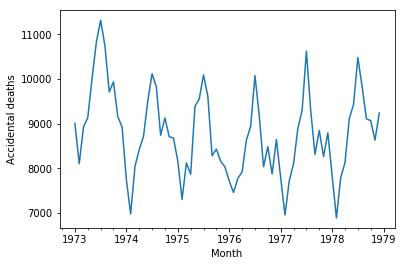

In [2]:
deaths = pd.read_csv('data/accidental-deaths-in-usa-monthly.csv',index_col=['Month'], parse_dates=['Month'])
deaths.rename(columns={'Accidental deaths in USA: monthly, 1973 ? 1978': 'num_deaths'}, inplace=True)
deaths['num_deaths'].plot()
plt.ylabel('Accidental deaths');

**Разделим на train и test. Будем прогнозировать 1978 - 1979 год**

In [3]:
train, test = deaths[deaths.index <'1978-01-01'], deaths[deaths.index >='1978-01-01']

Проверка стационарности и STL-декомпозиция ряда

Критерий Дики-Фуллера: p=0.102481


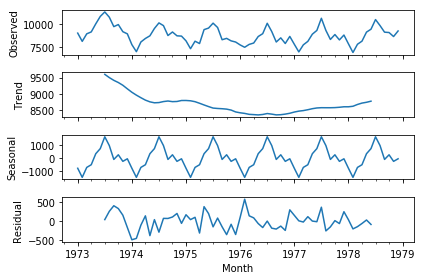

In [4]:
sm.tsa.seasonal_decompose(deaths['num_deaths']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(deaths['num_deaths'])[1])

критерий Дики-Фуллера не отверг нулевую гипотезу о нестационарности

Критерий Дики-Фуллера: p=0.014650


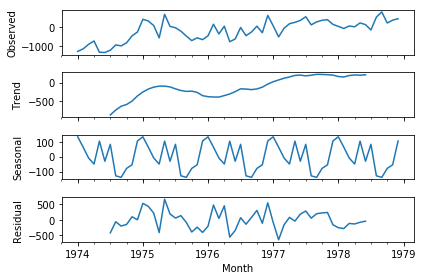

In [5]:
#Добавим сезонное дифференцирование
deaths['num_deaths_diff'] = deaths['num_deaths'] - deaths['num_deaths'].shift(12)
sm.tsa.seasonal_decompose(deaths['num_deaths_diff'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(deaths['num_deaths_diff'][12:])[1])

Критерий Дики-Фулера отвергает гипотезу о нестационарности

**Посмотрим на ACF и PACF**

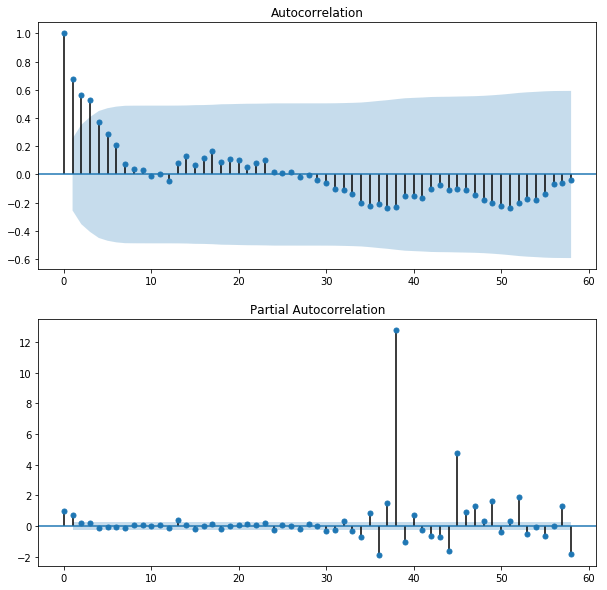

In [6]:
plt.figure(figsize = (10,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(deaths['num_deaths_diff'][13:].values.squeeze(), lags=58, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(deaths['num_deaths_diff'][13:].values.squeeze(), lags=58, ax=ax);

**Перебор параметров**

In [7]:
ps = range(0, 3)
d=1
qs = range(0, 1)
Ps = range(0, 3)
D=1
Qs = range(0, 3)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

27

In [15]:
%%time
results = []
best_aic = float("inf")

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train['num_deaths'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 2)
wrong parameters: (0, 0, 1, 1)
wrong parameters: (0, 0, 1, 2)
wrong parameters: (0, 0, 2, 2)
wrong parameters: (1, 0, 0, 1)
wrong parameters: (1, 0, 0, 2)
wrong parameters: (1, 0, 1, 1)
wrong parameters: (1, 0, 1, 2)
wrong parameters: (1, 0, 2, 2)
wrong parameters: (2, 0, 0, 1)
wrong parameters: (2, 0, 0, 2)
wrong parameters: (2, 0, 1, 1)
wrong parameters: (2, 0, 1, 2)
wrong parameters: (2, 0, 2, 2)
CPU times: user 13 s, sys: 117 ms, total: 13.1 s
Wall time: 6.88 s


In [16]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
6   (1, 0, 2, 0)  688.462410
9   (2, 0, 1, 0)  688.914603
10  (2, 0, 2, 0)  689.011795
5   (1, 0, 1, 0)  689.798252
7   (1, 0, 2, 1)  690.319378


In [17]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         num_deaths   No. Observations:                   60
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -340.231
Date:                            Sun, 02 Jun 2019   AIC                            688.462
Time:                                    11:53:30   BIC                            695.863
Sample:                                01-01-1973   HQIC                           691.247
                                     - 12-01-1977                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3123      0.140     -2.229      0.026      -0.587      -0.038
ar.S.L12      -0.5333      0.162   

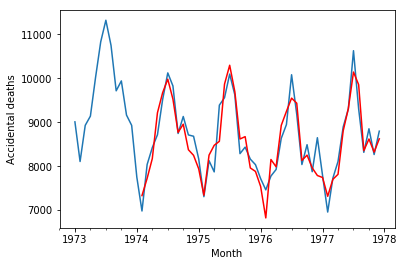

In [18]:
df_ = train.copy()
df_['model'] = best_model.fittedvalues
df_['num_deaths'].plot()
df_['model'][13:].plot(color='r')
plt.ylabel('Accidental deaths');

**Сделаем прогноз**

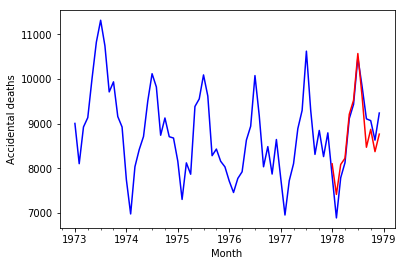

In [43]:
from dateutil.relativedelta import relativedelta

preds_arima = test[['num_deaths']].copy()
preds_arima['forecast'] = best_model.predict(start=60, end=72)
deaths['num_deaths'].plot(color='b')
preds_arima['forecast'].plot(color='r')
plt.ylabel('Accidental deaths');

In [20]:
mean_absolute_error(preds_arima['num_deaths'], preds_arima['forecast'])

270.99061609183155

**Теперь попробуем использоватать модель для прогноза**

In [62]:
df = deaths.copy()

# добавляем лаги исходного ряда в качестве признаков
for i in range(1, 10):
    df["lag_{}".format(i)] = df.num_deaths.shift(i)

train_df, test_df = df[deaths.index <'1978-01-01'], df[deaths.index >='1978-01-01']

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)

In [69]:
train_df.head()

,num_deaths,num_deaths_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9
Month,,,,,,,,,,,
1974-01-01,7750,-1257.0,8927.0,9161.0,9938.0,9713.0,10744.0,11317.0,10826.0,10017.0,9137.0
1974-02-01,6981,-1125.0,7750.0,8927.0,9161.0,9938.0,9713.0,10744.0,11317.0,10826.0,10017.0
1974-03-01,8038,-890.0,6981.0,7750.0,8927.0,9161.0,9938.0,9713.0,10744.0,11317.0,10826.0
1974-04-01,8422,-715.0,8038.0,6981.0,7750.0,8927.0,9161.0,9938.0,9713.0,10744.0,11317.0
1974-05-01,8714,-1303.0,8422.0,8038.0,6981.0,7750.0,8927.0,9161.0,9938.0,9713.0,10744.0


In [73]:
cols = [col for col in train_df.columns if col not in ['num_deaths', 'num_deaths_diff']]
cols

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9']

In [74]:
train_df.dropna(inplace = True)
mdl.fit(train_df[cols], train_df['num_deaths'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [75]:
test_df['predict'] = mdl.predict(test_df[cols])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


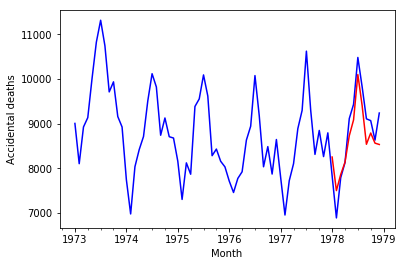

In [78]:
deaths['num_deaths'].plot(color='b')
test_df['predict'].plot(color='r')
plt.ylabel('Accidental deaths');

In [77]:
mean_absolute_error(test_df['num_deaths'], test_df['predict'])

355.2124166666665

**Модель ARIMA показала себя лучше с MAE = 270 против RF с MAE = 355**